In [1]:
import numpy as np
import torch
import rasterio
import pandas as pd
import torchvision.transforms as T
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold , GroupKFold
from sklearn.metrics import mean_squared_error
import joblib
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from scipy.stats import pearsonr ,kurtosis, skew, entropy
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage import exposure
import itertools
from tqdm import tqdm
import optuna
from scipy.stats import kurtosis, skew
import cv2
from sklearn.cluster import KMeans

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
test_df = pd.read_csv("/home/modar/Compete/Data/sample_answer.csv",header=None)
test_df.columns = ["file","aod"]

In [3]:
train_features = np.load("/home/modar/Compete/preprocessed_data/train_features_root.npy")
test_features = np.load("/home/modar/Compete/preprocessed_data/test_features_root.npy")
train_targets = np.load("/home/modar/Compete/preprocessed_data/train_labels_root.npy")
train_groups = np.load("/home/modar/Compete/preprocessed_data/train_groups_root.npy")
#augment_train_features = np.load("/home/modar/Compete/preprocessed_data/augment_train_features.npy")
#augment_train_targets = np.load("/home/modar/Compete/preprocessed_data/augment_train_labels.npy")
#feats_not_processed = np.load("/home/modar/Compete/preprocessed_data/train_features_root_before_processing.npy") 
train_features.shape , test_features.shape , train_targets.shape , train_groups.shape#, augment_train_features.shape , augment_train_targets.shape

((4104, 980), (1489, 2355), (1489,), (4104,))

In [5]:

import logging


logger = logging.getLogger()
logger.setLevel(logging.INFO) 
file_handler = logging.FileHandler('train_catboosts.log')
file_handler.setLevel(logging.INFO)

console_handler = logging.StreamHandler()
console_handler.setLevel(logging.INFO)

formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)
console_handler.setFormatter(formatter)

logger.addHandler(file_handler)
logger.addHandler(console_handler)

In [7]:
def train_catboost(X_data, y_data, catboost_params):
    kf = KFold(n_splits=10, shuffle=True, random_state=2004)
    
    oof_predictions = []
    models = []
    fold_results = []

    for fold, (train_idx, valid_idx) in enumerate(kf.split(X_data)):
        logger.info(f"Training fold {fold + 1}")
        
        X_train, X_valid = X_data[train_idx], X_data
        y_train, y_valid = y_data[train_idx], y_data
        train_pool = Pool(X_train, y_train)
        valid_pool = Pool(X_valid, y_valid)
        model = CatBoostRegressor(**catboost_params)
        
        model.fit(train_pool, eval_set=valid_pool, verbose=100)
        models.append(model)
        
        oof_predictions.append(model.predict(X_valid))
        pearson_corr = pearsonr(y_valid, oof_predictions[fold])[0]
        fold_results.append(pearson_corr)
        logger.info(f"Pearson R for fold {fold + 1}: {pearson_corr:.4f}")
    oof_predictions = np.array(oof_predictions)
    oof_predictions = np.mean(oof_predictions,axis=0)
    overall_pearson_corr = pearsonr(y_data, oof_predictions)[0]
    logger.info(f"Overall Pearson R: {overall_pearson_corr:.4f}")

    return models, oof_predictions

def train_catboost_groups(X_data, y_data, groups, catboost_params):
    gkf = GroupKFold(n_splits=5)

    oof_predictions = np.zeros(len(y_data))
    models = []
    fold_results = []

    for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_data, y_data, groups=groups)):
        logger.info(f"Training fold {fold + 1}")
        
        X_train, X_valid = X_data[train_idx], X_data[valid_idx]
        y_train, y_valid = y_data[train_idx], y_data[valid_idx]
        
        train_pool = Pool(X_train, y_train)
        valid_pool = Pool(X_valid, y_valid)
        
        model = CatBoostRegressor(**catboost_params)
        model.fit(train_pool, eval_set=valid_pool, verbose=100)
        models.append(model)
        
        oof_predictions[valid_idx] = model.predict(X_valid)
        
        pearson_corr = pearsonr(y_valid, oof_predictions[valid_idx])[0]
        fold_results.append(pearson_corr)
        logger.info(f"Pearson R for fold {fold + 1}: {pearson_corr:.4f}")
    
    overall_pearson_corr = pearsonr(y_data, oof_predictions)[0]
    logger.info(f"Overall Pearson R: {overall_pearson_corr:.4f}")

    return models, oof_predictions

In [ ]:
def objective(trial):
    catboost_params = {
        'iterations': trial.suggest_int('iterations', 1000, 1300),
        'depth': trial.suggest_int('depth', 6, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.07),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
    }

    models, oof_predictions = train_catboost(train_features, train_targets, catboost_params)

    overall_pearson_corr = pearsonr(train_targets, oof_predictions)[0]

    return -overall_pearson_corr


In [ ]:
########################## Use Optuna to finb best parameters############################################################################################################

study_path = '/home/modar/Compete/catboost_study_0.005.pkl'
try:
    study = joblib.load(study_path)
    print("Loaded existing study.")
except FileNotFoundError:
    study = optuna.create_study(direction='minimize')
    print("Created new study.")

try:
    study.optimize(objective, n_trials=3)
    
    joblib.dump(study, study_path)
    print("Study saved.")
except KeyboardInterrupt:
    print("Optimization interrupted. Saving the current study...")
    joblib.dump(study, study_path)

print("Best trial:")
trial = study.best_trial

print(f"Value: {-trial.value}") 
print("Best hyperparameters: ", trial.params)

best_params = trial.params
models, oof_predictions = train_catboost(train_features, train_targets, best_params)

########################################################################################################################################################################################################################

In [20]:

catboost_params =  {'iterations': 1291, 'depth': 7, 'learning_rate': 0.05010892239806417, 'l2_leaf_reg': 5.6539994243603005}

models, oof_predictions = train_catboost(train_features,train_targets, catboost_params)

2024-10-30 22:45:25,995 - INFO - Training fold 1


0:	learn: 0.2172687	test: 0.2138645	best: 0.2138645 (0)	total: 277ms	remaining: 6m 54s
100:	learn: 0.0564738	test: 0.0563951	best: 0.0563951 (100)	total: 34.2s	remaining: 8m 8s
200:	learn: 0.0400333	test: 0.0409608	best: 0.0409608 (200)	total: 1m 8s	remaining: 7m 34s
300:	learn: 0.0311474	test: 0.0328667	best: 0.0328667 (300)	total: 1m 39s	remaining: 6m 49s
400:	learn: 0.0255462	test: 0.0279574	best: 0.0279574 (400)	total: 2m 16s	remaining: 6m 26s
500:	learn: 0.0213383	test: 0.0244122	best: 0.0244122 (500)	total: 2m 48s	remaining: 5m 46s
600:	learn: 0.0181666	test: 0.0218686	best: 0.0218686 (600)	total: 3m 30s	remaining: 5m 25s
700:	learn: 0.0156509	test: 0.0199635	best: 0.0199635 (700)	total: 4m 7s	remaining: 4m 52s
800:	learn: 0.0136475	test: 0.0185616	best: 0.0185616 (800)	total: 4m 43s	remaining: 4m 17s
900:	learn: 0.0119092	test: 0.0174170	best: 0.0174170 (900)	total: 5m 18s	remaining: 3m 39s
1000:	learn: 0.0105472	test: 0.0165661	best: 0.0165661 (1000)	total: 5m 57s	remaining: 3m

2024-10-30 22:52:14,533 - INFO - Pearson R for fold 1: 0.9979
2024-10-30 22:52:14,534 - INFO - Training fold 2


1499:	learn: 0.0058674	test: 0.0142130	best: 0.0142130 (1499)	total: 8m 34s	remaining: 0us

bestTest = 0.01421302193
bestIteration = 1499

0:	learn: 0.2130346	test: 0.2135722	best: 0.2135722 (0)	total: 282ms	remaining: 7m 2s
100:	learn: 0.0562592	test: 0.0564693	best: 0.0564693 (100)	total: 29.2s	remaining: 6m 52s
200:	learn: 0.0398611	test: 0.0410979	best: 0.0410979 (200)	total: 58.3s	remaining: 6m 22s
300:	learn: 0.0308139	test: 0.0328876	best: 0.0328876 (300)	total: 1m 24s	remaining: 5m 42s
400:	learn: 0.0252461	test: 0.0280885	best: 0.0280885 (400)	total: 1m 56s	remaining: 5m 23s
500:	learn: 0.0210813	test: 0.0246565	best: 0.0246565 (500)	total: 2m 25s	remaining: 4m 54s
600:	learn: 0.0179424	test: 0.0221736	best: 0.0221736 (600)	total: 2m 52s	remaining: 4m 20s
700:	learn: 0.0154545	test: 0.0203292	best: 0.0203292 (700)	total: 3m 18s	remaining: 3m 49s
800:	learn: 0.0134105	test: 0.0189230	best: 0.0189230 (800)	total: 3m 45s	remaining: 3m 18s
900:	learn: 0.0117207	test: 0.0178346	bes

2024-10-30 22:58:58,134 - INFO - Pearson R for fold 2: 0.9977
2024-10-30 22:58:58,135 - INFO - Training fold 3


1499:	learn: 0.0057972	test: 0.0148703	best: 0.0148703 (1499)	total: 7m 12s	remaining: 0us

bestTest = 0.01487027568
bestIteration = 1499

0:	learn: 0.2166898	test: 0.2139208	best: 0.2139208 (0)	total: 281ms	remaining: 7m 1s
100:	learn: 0.0562318	test: 0.0575978	best: 0.0575978 (100)	total: 31.9s	remaining: 7m 31s
200:	learn: 0.0397221	test: 0.0420059	best: 0.0420059 (200)	total: 1m 6s	remaining: 7m 17s
300:	learn: 0.0305895	test: 0.0336337	best: 0.0336337 (300)	total: 1m 37s	remaining: 6m 38s
400:	learn: 0.0248918	test: 0.0286348	best: 0.0286348 (400)	total: 2m 4s	remaining: 5m 47s
500:	learn: 0.0208821	test: 0.0253844	best: 0.0253844 (500)	total: 2m 31s	remaining: 5m 6s
600:	learn: 0.0178312	test: 0.0230383	best: 0.0230383 (600)	total: 2m 58s	remaining: 4m 29s
700:	learn: 0.0154744	test: 0.0213671	best: 0.0213671 (700)	total: 3m 27s	remaining: 3m 59s
800:	learn: 0.0134817	test: 0.0200426	best: 0.0200426 (800)	total: 3m 56s	remaining: 3m 28s
900:	learn: 0.0117523	test: 0.0189730	best:

2024-10-30 23:05:42,976 - INFO - Pearson R for fold 3: 0.9974
2024-10-30 23:05:42,977 - INFO - Training fold 4


1499:	learn: 0.0058068	test: 0.0161421	best: 0.0161421 (1499)	total: 7m 13s	remaining: 0us

bestTest = 0.01614205505
bestIteration = 1499

0:	learn: 0.2158001	test: 0.2136690	best: 0.2136690 (0)	total: 285ms	remaining: 7m 7s
100:	learn: 0.0565309	test: 0.0585398	best: 0.0585398 (100)	total: 32.1s	remaining: 7m 33s
200:	learn: 0.0394014	test: 0.0426211	best: 0.0426211 (200)	total: 1m 8s	remaining: 7m 38s
300:	learn: 0.0304309	test: 0.0347551	best: 0.0347551 (300)	total: 1m 38s	remaining: 6m 40s
400:	learn: 0.0250327	test: 0.0303686	best: 0.0303686 (400)	total: 2m 7s	remaining: 5m 56s
500:	learn: 0.0211623	test: 0.0274028	best: 0.0274028 (500)	total: 2m 34s	remaining: 5m 13s
600:	learn: 0.0180121	test: 0.0251521	best: 0.0251521 (600)	total: 3m 1s	remaining: 4m 35s
700:	learn: 0.0155039	test: 0.0235424	best: 0.0235424 (700)	total: 3m 31s	remaining: 4m 3s
800:	learn: 0.0134609	test: 0.0223137	best: 0.0223137 (800)	total: 4m	remaining: 3m 32s
900:	learn: 0.0117690	test: 0.0213964	best: 0.02

2024-10-30 23:12:30,614 - INFO - Pearson R for fold 4: 0.9964
2024-10-30 23:12:30,615 - INFO - Training fold 5


1499:	learn: 0.0057117	test: 0.0189372	best: 0.0189372 (1499)	total: 7m 25s	remaining: 0us

bestTest = 0.01893715577
bestIteration = 1499

0:	learn: 0.2140794	test: 0.2143271	best: 0.2143271 (0)	total: 286ms	remaining: 7m 7s
100:	learn: 0.0562014	test: 0.0572823	best: 0.0572823 (100)	total: 27.4s	remaining: 6m 20s
200:	learn: 0.0398311	test: 0.0418923	best: 0.0418923 (200)	total: 57s	remaining: 6m 10s
300:	learn: 0.0306259	test: 0.0336386	best: 0.0336386 (300)	total: 1m 28s	remaining: 5m 58s
400:	learn: 0.0251647	test: 0.0290188	best: 0.0290188 (400)	total: 1m 58s	remaining: 5m 28s
500:	learn: 0.0209767	test: 0.0256892	best: 0.0256892 (500)	total: 2m 35s	remaining: 5m 15s
600:	learn: 0.0178947	test: 0.0233788	best: 0.0233788 (600)	total: 3m 2s	remaining: 4m 36s
700:	learn: 0.0153647	test: 0.0215886	best: 0.0215886 (700)	total: 3m 29s	remaining: 4m 1s
800:	learn: 0.0132683	test: 0.0202257	best: 0.0202257 (800)	total: 3m 56s	remaining: 3m 28s
900:	learn: 0.0116199	test: 0.0192239	best: 0

2024-10-30 23:19:20,890 - INFO - Pearson R for fold 5: 0.9972
2024-10-30 23:19:20,891 - INFO - Training fold 6


0:	learn: 0.2050414	test: 0.2142291	best: 0.2142291 (0)	total: 284ms	remaining: 7m 5s
100:	learn: 0.0551357	test: 0.0655137	best: 0.0655137 (100)	total: 32.3s	remaining: 7m 36s
200:	learn: 0.0410946	test: 0.0521423	best: 0.0521423 (200)	total: 1m 1s	remaining: 6m 46s
300:	learn: 0.0313199	test: 0.0442634	best: 0.0442634 (300)	total: 1m 28s	remaining: 5m 58s
400:	learn: 0.0253446	test: 0.0401644	best: 0.0401644 (400)	total: 2m	remaining: 5m 36s
500:	learn: 0.0212064	test: 0.0376817	best: 0.0376817 (500)	total: 2m 30s	remaining: 5m 4s
600:	learn: 0.0180435	test: 0.0359951	best: 0.0359951 (600)	total: 2m 57s	remaining: 4m 28s
700:	learn: 0.0154701	test: 0.0347641	best: 0.0347641 (700)	total: 3m 31s	remaining: 4m 5s
800:	learn: 0.0134452	test: 0.0339288	best: 0.0339288 (800)	total: 4m 1s	remaining: 3m 33s
900:	learn: 0.0118229	test: 0.0333011	best: 0.0333011 (900)	total: 4m 35s	remaining: 3m 6s
1000:	learn: 0.0104472	test: 0.0328502	best: 0.0328502 (1000)	total: 5m 7s	remaining: 2m 36s
110

2024-10-30 23:26:11,063 - INFO - Pearson R for fold 6: 0.9899
2024-10-30 23:26:11,064 - INFO - Training fold 7


1499:	learn: 0.0059088	test: 0.0317749	best: 0.0317749 (1499)	total: 7m 32s	remaining: 0us

bestTest = 0.03177491903
bestIteration = 1499

0:	learn: 0.2138576	test: 0.2137389	best: 0.2137389 (0)	total: 287ms	remaining: 7m 10s
100:	learn: 0.0556997	test: 0.0575149	best: 0.0575149 (100)	total: 35s	remaining: 8m 14s
200:	learn: 0.0395116	test: 0.0428393	best: 0.0428393 (200)	total: 1m 4s	remaining: 7m 4s
300:	learn: 0.0306404	test: 0.0353374	best: 0.0353374 (300)	total: 1m 31s	remaining: 6m 9s
400:	learn: 0.0249467	test: 0.0308159	best: 0.0308159 (400)	total: 1m 59s	remaining: 5m 28s
500:	learn: 0.0209479	test: 0.0278193	best: 0.0278193 (500)	total: 2m 28s	remaining: 4m 58s
600:	learn: 0.0180310	test: 0.0257859	best: 0.0257859 (600)	total: 2m 55s	remaining: 4m 24s
700:	learn: 0.0156017	test: 0.0242359	best: 0.0242359 (700)	total: 3m 28s	remaining: 3m 59s
800:	learn: 0.0136802	test: 0.0230877	best: 0.0230877 (800)	total: 3m 57s	remaining: 3m 29s
900:	learn: 0.0120751	test: 0.0222202	best: 

2024-10-30 23:33:01,882 - INFO - Pearson R for fold 7: 0.9960
2024-10-30 23:33:01,883 - INFO - Training fold 8


1499:	learn: 0.0060944	test: 0.0197192	best: 0.0197192 (1499)	total: 7m 17s	remaining: 0us

bestTest = 0.01971921888
bestIteration = 1499

0:	learn: 0.2153239	test: 0.2141585	best: 0.2141585 (0)	total: 286ms	remaining: 7m 8s
100:	learn: 0.0570988	test: 0.0568304	best: 0.0568304 (100)	total: 32.7s	remaining: 7m 37s
200:	learn: 0.0401412	test: 0.0408457	best: 0.0408457 (200)	total: 1m	remaining: 6m 29s
300:	learn: 0.0314918	test: 0.0329425	best: 0.0329425 (300)	total: 1m 27s	remaining: 5m 49s
400:	learn: 0.0254202	test: 0.0276007	best: 0.0276007 (400)	total: 1m 54s	remaining: 5m 15s
500:	learn: 0.0210720	test: 0.0239327	best: 0.0239327 (500)	total: 2m 22s	remaining: 4m 43s
600:	learn: 0.0179246	test: 0.0213955	best: 0.0213955 (600)	total: 2m 49s	remaining: 4m 13s
700:	learn: 0.0155616	test: 0.0195950	best: 0.0195950 (700)	total: 3m 19s	remaining: 3m 47s
800:	learn: 0.0135650	test: 0.0181539	best: 0.0181539 (800)	total: 3m 48s	remaining: 3m 20s
900:	learn: 0.0120050	test: 0.0171176	best: 

2024-10-30 23:39:54,529 - INFO - Pearson R for fold 8: 0.9980
2024-10-30 23:39:54,530 - INFO - Training fold 9


1499:	learn: 0.0061334	test: 0.0139048	best: 0.0139048 (1499)	total: 7m 27s	remaining: 0us

bestTest = 0.01390475446
bestIteration = 1499

0:	learn: 0.2153054	test: 0.2135672	best: 0.2135672 (0)	total: 288ms	remaining: 7m 12s
100:	learn: 0.0563331	test: 0.0570709	best: 0.0570709 (100)	total: 27.7s	remaining: 6m 23s
200:	learn: 0.0399232	test: 0.0417334	best: 0.0417334 (200)	total: 57.8s	remaining: 6m 13s
300:	learn: 0.0309541	test: 0.0336546	best: 0.0336546 (300)	total: 1m 24s	remaining: 5m 39s
400:	learn: 0.0251854	test: 0.0287009	best: 0.0287009 (400)	total: 1m 54s	remaining: 5m 15s
500:	learn: 0.0211369	test: 0.0254050	best: 0.0254050 (500)	total: 2m 26s	remaining: 4m 55s
600:	learn: 0.0180942	test: 0.0230719	best: 0.0230719 (600)	total: 2m 57s	remaining: 4m 27s
700:	learn: 0.0157322	test: 0.0214004	best: 0.0214004 (700)	total: 3m 37s	remaining: 4m 11s
800:	learn: 0.0137698	test: 0.0200736	best: 0.0200736 (800)	total: 4m 24s	remaining: 3m 56s
900:	learn: 0.0120584	test: 0.0189689	be

2024-10-30 23:46:54,104 - INFO - Pearson R for fold 9: 0.9974
2024-10-30 23:46:54,105 - INFO - Training fold 10


1499:	learn: 0.0060679	test: 0.0160269	best: 0.0160269 (1499)	total: 9m 11s	remaining: 0us

bestTest = 0.01602685218
bestIteration = 1499

0:	learn: 0.2122842	test: 0.2142415	best: 0.2142415 (0)	total: 294ms	remaining: 7m 20s
100:	learn: 0.0566153	test: 0.0600077	best: 0.0600077 (100)	total: 45.6s	remaining: 11m 12s
200:	learn: 0.0428313	test: 0.0465449	best: 0.0465449 (200)	total: 1m 21s	remaining: 9m 8s
300:	learn: 0.0330257	test: 0.0377329	best: 0.0377329 (300)	total: 2m 3s	remaining: 8m 38s
400:	learn: 0.0267395	test: 0.0325503	best: 0.0325503 (400)	total: 2m 44s	remaining: 7m 53s
500:	learn: 0.0222486	test: 0.0291666	best: 0.0291666 (500)	total: 3m 21s	remaining: 7m 2s
600:	learn: 0.0188532	test: 0.0268253	best: 0.0268253 (600)	total: 4m 9s	remaining: 6m 33s
700:	learn: 0.0162285	test: 0.0251221	best: 0.0251221 (700)	total: 4m 52s	remaining: 5m 52s
800:	learn: 0.0140791	test: 0.0238575	best: 0.0238575 (800)	total: 5m 35s	remaining: 5m 9s
900:	learn: 0.0122822	test: 0.0229051	best:

2024-10-30 23:54:01,684 - INFO - Pearson R for fold 10: 0.9958
2024-10-30 23:54:01,685 - INFO - Overall Pearson R: 0.9992


1499:	learn: 0.0060932	test: 0.0204365	best: 0.0204365 (1499)	total: 9m 50s	remaining: 0us

bestTest = 0.02043646593
bestIteration = 1499



In [ ]:
testing_the_predictions = np.array([model.predict(train_features) for model in models])
testing_the_predictions.shape 

In [ ]:
np.save("/home/modar/Compete/preprocessed_data/meta_train.npy", testing_the_predictions)

In [ ]:
testing_the_predictions = np.mean(testing_the_predictions,axis=0)
testing_the_predictions.shape , train_targets.shape ,  pearsonr(testing_the_predictions,train_targets)

In [ ]:
from sklearn.metrics import mean_squared_error as mse
results_df = pd.DataFrame({
    'Image_Index': np.arange(len(train_targets)),
    'True_Values': train_targets,
    'Predictions': oof_predictions
})

results_df['MSE'] = (results_df['True_Values'] - results_df['Predictions']) ** 2

sorted_results = results_df.sort_values(by='MSE')

best_images = sorted_results.head(10)  
worst_images = sorted_results.tail(200) 

print("Best Performing Images (Lowest MSE):")
print(best_images)

print("\nWorst Performing Images (Highest MSE):")
print(worst_images)

print("\nWorst Performing indices (Highest MSE):")
print(sorted_results.tail(200)['Image_Index'].values)

print("\nBest Performing indices (Highest MSE):")
print(sorted_results.head(200)['Image_Index'].values)

In [ ]:
df = pd.DataFrame({
    'True_Target': train_targets,
    'Predictions': oof_predictions
})

df.to_csv('/home/modar/Compete/models_predictions/catboost_predictions_and_targets.csv', index=False)

print("DataFrame saved to 'catboost_predictions_and_targets.csv'")

In [ ]:
np.save("/home/modar/Compete/models_predictions/catboost_train_preds.npy" , oof_predictions)
np.save("/home/modar/Compete/models_predictions/train_labels.npy" , train_targets)

train_targets.shape , oof_predictions.shape

In [ ]:
train_targets[:5].tolist()

In [ ]:
oof_predictions[:5].tolist()

In [ ]:
###############################################################################################################################################################
##################################################### Here is features importance analysis ##########################################################################################################
###############################################################################################################################################################

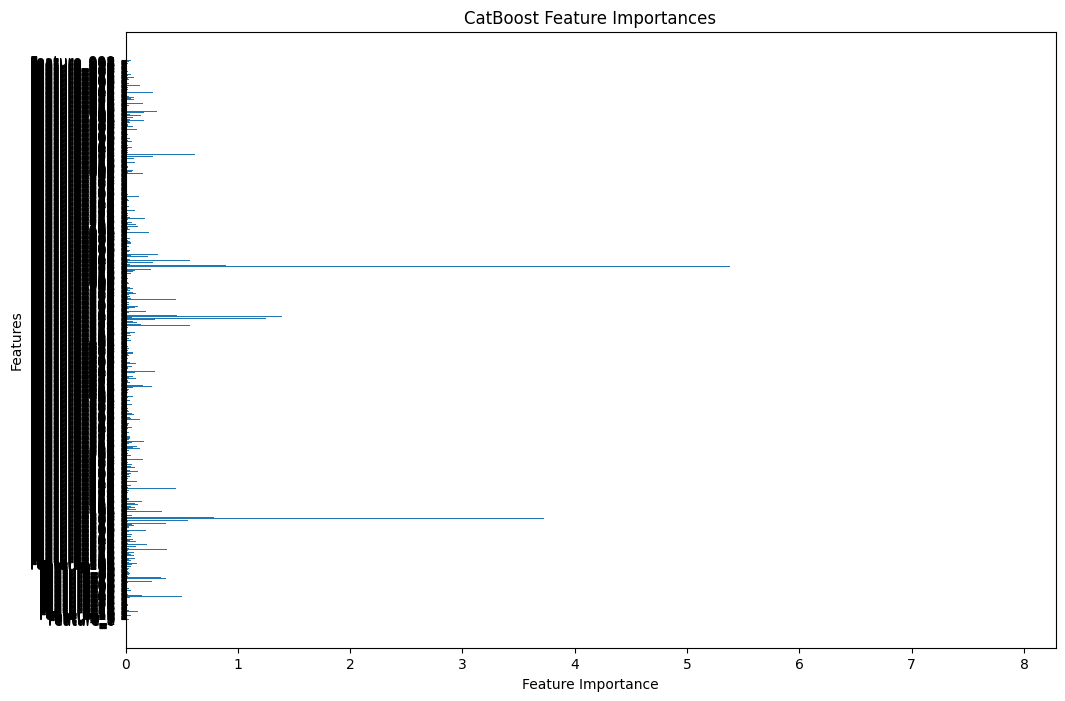

In [97]:
feature_importances = np.mean([model.feature_importances_ for model in models], axis=0)
feature_names = [f'Feature_{i}' for i in range(train_features[:,filtered_features].shape[1])]

plt.figure(figsize=(12, 8))
plt.barh(feature_names, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('CatBoost Feature Importances')
plt.show()

In [98]:
feature_importances[:10] , feature_names[:10] , feature_importances.max() / np.cumsum(feature_importances)[-1] * 100

(array([0.02933455, 0.00651655, 0.00184835, 0.04027615, 0.00406379,
        0.01686722, 0.032555  , 0.04582854, 0.04614484, 0.00274502]),
 ['Feature_0',
  'Feature_1',
  'Feature_2',
  'Feature_3',
  'Feature_4',
  'Feature_5',
  'Feature_6',
  'Feature_7',
  'Feature_8',
  'Feature_9'],
 7.885944975862295)

In [99]:

feature_importances_sorted = np.flip(np.sort(feature_importances))
feature_importances_sorted[0:700].cumsum()[-1]

97.84713611121066

In [100]:
np.min(feature_importances_sorted[0:700])

0.014137059324289825

In [101]:
np.max(feature_importances_sorted)

7.885944975862292

In [102]:
feature_names = np.array(feature_names)
feature_importances = np.array(feature_importances)
feature_names_filtered = feature_names[feature_importances >= 0.014137059324289825]
feature_names_filtered.shape , feature_names.shape

((700,), (1000,))

In [61]:
feature_names_filtered[0][8:]

'4'

In [103]:
filtered_features = []
for name in feature_names_filtered:
    filtered_features.append(name[8:])
filtered_features = np.array(filtered_features,dtype=np.uint)
filtered_features.shape

(700,)

In [ ]:
###############################################################################################################################################################
####################################################################################################################################################################################################################
############################################################################################################################################################### ##########################################################################################################
###############################################################################################################################################################

In [11]:
test_features.shape 

(1489, 2355)

In [105]:
### Use this cell if the filtered features were computed
test_features = test_features[:,filtered_features]
test_features.shape

(1489, 700)

In [21]:
test_predictions = [(model.predict(test_features)) for model in models]
len(test_predictions) , test_predictions[0].shape , test_features.shape

(10, (1489,), (1489, 2355))

In [13]:
np.save("/home/modar/Compete/preprocessed_data/meta_test.npy", test_predictions)

In [ ]:
weights = [0.9968,0.9963,0.9982,0.9946,0.9980,0.9972,0.9973,0.9887 ,0.9948 , 0.9980]
len(weights)

In [22]:
#test_predictions = np.average(test_predictions, axis=0,weights=weights)
test_predictions = np.mean(test_predictions, axis=0)

In [23]:
test_predictions.shape

(1489,)

In [24]:
test_predictions_original = test_predictions
test_predictions_original.shape

(1489,)

In [25]:

test_df['aod'] = test_predictions
test_df[['file', 'aod']].to_csv("/home/modar/Compete/models_predictions/larg_iter2.csv", index=False, header=False)

Predictions saved to solutionvv2.csv
